---
title: "Pandas and annoyances of time-series"
author: "Damien Martin"
date: "2025-02-19"
categories: [pandas, timeseries]
---

# Problem

We have a time-series, where we have multiple groups, and some missing dates. For example, let's look at two customers and suppose we have the following data

```csv
client_id,date,amount_spent
1,2025-01-01, 100.00
1,2025-01-08, 120.00
1,2025-01-15, 140.00
1,2025-01-29, 300.00
2,2025-01-01, 900.00
2,2025-01-15, 600.00
2,2025-02-05, 700.00
```

We want to produce a rolling 3-week average for each client. We need to be a little careful, because some clients have 0 spend.

In [1]:
import pandas as pd
import plotnine as p9
from io import StringIO

sales = pd.read_csv(StringIO("""client_id,date,amount_spent
1,2025-01-01, 100.00
1,2025-01-08, 120.00
1,2025-01-15, 140.00
1,2025-01-29, 300.00
2,2025-01-01, 900.00
2,2025-01-15, 600.00
2,2025-02-05, 700.00"""))
sales['date'] = pd.to_datetime(sales['date'])

# Solution

## Rolling average without the client (manual)

The simple thing to do is what happens if we ignore the client id, and just look for a rolling three week average sales? 

Note that there are no sales for the week of 2025-01-22 for either client!

In [2]:
sales

,client_id,date,amount_spent
0,1,2025-01-01,100.0
1,1,2025-01-08,120.0
2,1,2025-01-15,140.0
3,1,2025-01-29,300.0
4,2,2025-01-01,900.0
5,2,2025-01-15,600.0
6,2,2025-02-05,700.0


We can generate the amount each week:

In [3]:
weekly_sales = sales.groupby('date')['amount_spent'].sum().reset_index()
weekly_sales

,date,amount_spent
0,2025-01-01,1000.0
1,2025-01-08,120.0
2,2025-01-15,740.0
3,2025-01-29,300.0
4,2025-02-05,700.0


Let do the naive thing (note this is NOT correct):

In [4]:
sales.groupby('date')['amount_spent'].sum().rolling(3).mean()

date
2025-01-01           NaN
2025-01-08           NaN
2025-01-15    620.000000
2025-01-29    386.666667
2025-02-05    580.000000
Name: amount_spent, dtype: float64

Looking at 2025-02-06, the calculation was
```
"Rolling average" = (700 + 300 + 740) / 3 = 580.0
```
but we should have 2025-02-22 in there as well. The correct 3-week rolling average would have been
```
Rolling average = (700 + 300 + 0) / 3 = 333.33
```

We can fix this by creating a weekly "spine" and joining it:


In [5]:
spine = pd.DataFrame({'date': pd.date_range('2025-01-01', '2025-02-06', freq='W-WED')})
spine

,date
0,2025-01-01
1,2025-01-08
2,2025-01-15
3,2025-01-22
4,2025-01-29
5,2025-02-05


In [6]:
weekly_sales_none_missing = spine.merge(weekly_sales, how='left').fillna(0)
weekly_sales_none_missing

,date,amount_spent
0,2025-01-01,1000.0
1,2025-01-08,120.0
2,2025-01-15,740.0
3,2025-01-22,0.0
4,2025-01-29,300.0
5,2025-02-05,700.0


In [7]:
weekly_sales_none_missing.set_index('date').amount_spent.rolling(3).mean()

date
2025-01-01           NaN
2025-01-08           NaN
2025-01-15    620.000000
2025-01-22    286.666667
2025-01-29    346.666667
2025-02-05    333.333333
Name: amount_spent, dtype: float64

## Rolling weekly sales per client

We have a grouper, but this doesn't do what we would expect

In [8]:
sales.groupby(['client_id', pd.Grouper(key='date', freq='W-WED')]).amount_spent.sum()

client_id  date      
1          2025-01-01    100.0
           2025-01-08    120.0
           2025-01-15    140.0
           2025-01-29    300.0
2          2025-01-01    900.0
           2025-01-15    600.0
           2025-02-05    700.0
Name: amount_spent, dtype: float64

In [9]:
spine_index = (
    pd.MultiIndex.from_product([spine['date'], sales.client_id.unique()], names=['date', 'client_id'])
)
sales_fill_in = sales.set_index(['date', 'client_id']).reindex(spine_index, fill_value=0).reset_index()
sales_fill_in

,date,client_id,amount_spent
0,2025-01-01,1,100.0
1,2025-01-01,2,900.0
2,2025-01-08,1,120.0
3,2025-01-08,2,0.0
4,2025-01-15,1,140.0
5,2025-01-15,2,600.0
6,2025-01-22,1,0.0
7,2025-01-22,2,0.0
8,2025-01-29,1,300.0
9,2025-01-29,2,0.0


Now we can calculate the rolling average:

In [10]:
sales_fill_in.groupby(['client_id'])['amount_spent'].rolling(3).mean()

client_id    
1          0            NaN
           2            NaN
           4     120.000000
           6      86.666667
           8     146.666667
           10    100.000000
2          1            NaN
           3            NaN
           5     500.000000
           7     200.000000
           9     200.000000
           11    233.333333
Name: amount_spent, dtype: float64

Or, if we wanted to join to the original dataframe, we would need a `droplevel(0)` to eliminate the client_id

In [11]:
sales_fill_in['rolling_avg'] = sales_fill_in.groupby(['client_id'])['amount_spent'].rolling(3).mean().droplevel(0)
sales_fill_in

,date,client_id,amount_spent,rolling_avg
0,2025-01-01,1,100.0,NaN
1,2025-01-01,2,900.0,NaN
2,2025-01-08,1,120.0,NaN
3,2025-01-08,2,0.0,NaN
4,2025-01-15,1,140.0,120.000000
5,2025-01-15,2,600.0,500.000000
6,2025-01-22,1,0.0,86.666667
7,2025-01-22,2,0.0,200.000000
8,2025-01-29,1,300.0,146.666667
9,2025-01-29,2,0.0,200.000000


/Users/damienmartin/anaconda3/envs/blog/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


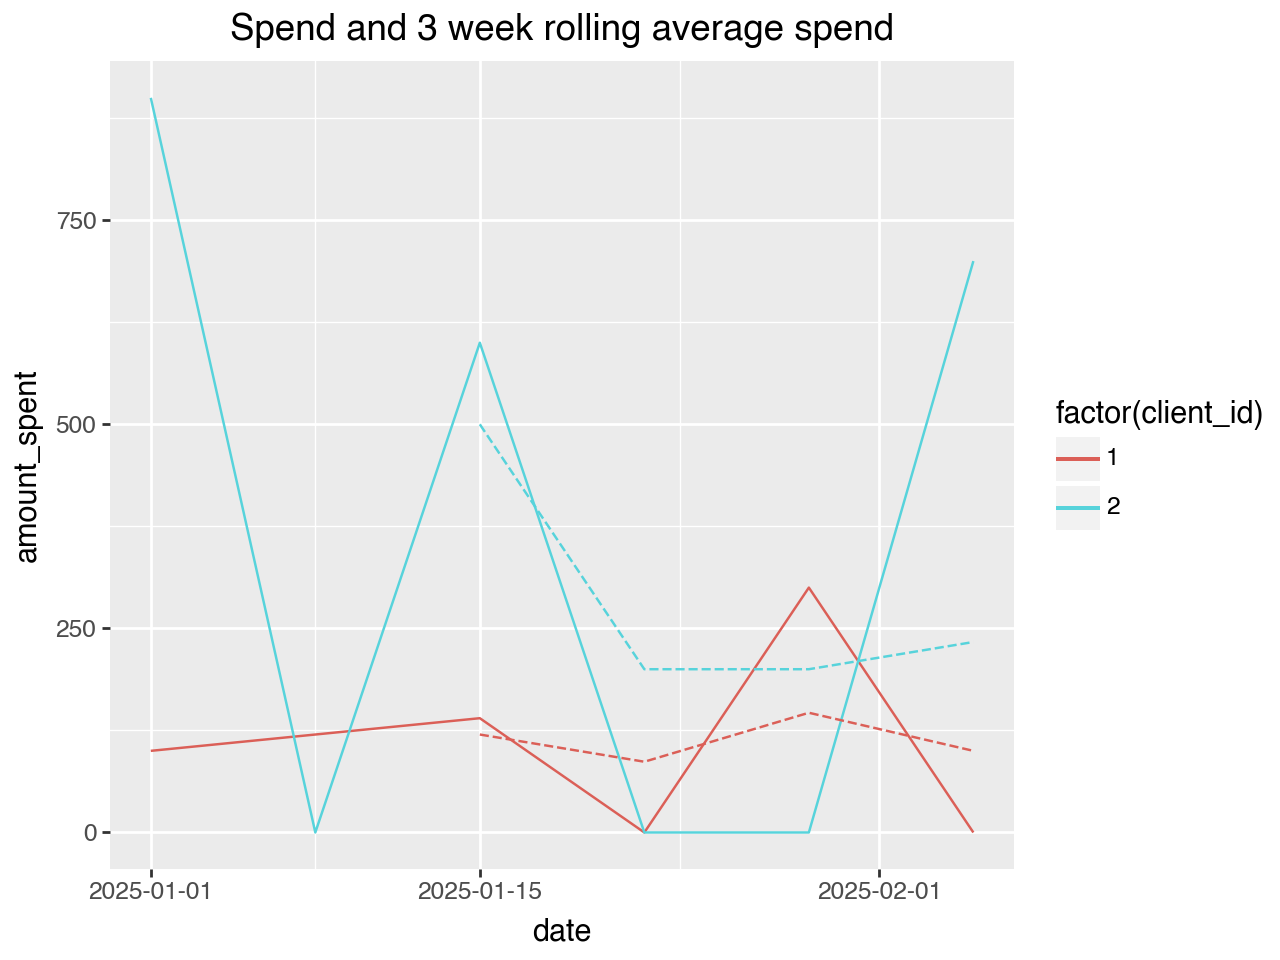

In [12]:
(
    p9.ggplot(sales_fill_in, p9.aes(x='date', color='factor(client_id)', group='client_id'))
    + p9.geom_line(mapping=p9.aes(y='amount_spent'))
    + p9.geom_line(mapping=p9.aes(y='rolling_avg'), linetype='dashed')
    + p9.labs(
        title="Spend and 3 week rolling average spend"
    )
)